## Tutorial 4
Solving the 1D unsteady diffusion equation using a Physics Informed Neural Network (PINN).  
The Equation is given by:
$$\frac {\partial u} {\partial t} - \mu \frac {\partial^2 u} {\partial x^2} = 0$$
The Domain for $x$ and $t$ are $x\in [0,1]$, and $t\in [0,1]$.  
The ICs/BSs are (here $T=1$):
$$u(x,t=0)=sin(\frac {2\pi x} {T})$$
$$u(x=0,t)=0$$
$$u(x=1,t)=0$$
$$u_x(x=0,t)=u_x(x=1,t)$$


In [57]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt


### Define PINNs network class with Fourier Feature Mapping

In [58]:
class ffm(nn.Module):
    def __init__(self, in_dim, out_dim, std_dev = 2):
        super().__init__()
        self.omega = nn.Parameter(torch.randn(out_dim, in_dim) * std_dev) # Length of hidden layer is rows, 

    def forward(self, x):
        return torch.cos(F.F.linear(x, self.omega))

class PINNs_net(nn.Module):    
    def __init__(self, in_dim=3, HL_dim=32, out_dim=2, activation=nn.Tanh()):
        """
        Parameters
        -------------
        in_dim: the input dimensions - number of independant variables
        HL_dim: the width of the network
        out_dim: the output dimensions - number of dependant variables
        activation: The activation function you wish to use in the network - the default is nn.Tanh()
        """
        super().__init__()
        
        # define the network architecture
        network = [nn.Linear(in_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]
        
        # define the network using sequential method
        self.u = nn.Sequential(*network) 
    
    def forward(self, x, y, t):
        return self.u(torch.cat((x, y, t), 1))
    
    
    def compute_loss(self, x, y, t, r, Nx, Ny, Nt):
        """
        This is the physics part really
        """
        x.requires_grad=True
        y.requires_grad=True
        t.requires_grad=True
        u = self.u(torch.cat((x, y, t), 1))

        # compute PDE derivatives using auto grad
        u_x = grad(u[:, 0], x, grad_outputs=torch.ones_like(u[:, 0]), create_graph=True)[0]
        u_y = grad(u[:, 0], y, grad_outputs=torch.ones_like(u[:, 0]), create_graph=True)[0]
        u_t = grad(u[:, 0], t, grad_outputs=torch.ones_like(u[:, 0]), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        
        v_x = grad(u[:, 1], x, grad_outputs=torch.ones_like(u[:, 1]), create_graph=True)[0]  # Change 5: Added gradients for v
        v_y = grad(u[:, 1], y, grad_outputs=torch.ones_like(u[:, 1]), create_graph=True)[0]
        v_t = grad(u[:, 1], t, grad_outputs=torch.ones_like(u[:, 1]), create_graph=True)[0]
        v_xx = grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
        
        # set a loss function to apply to each of the physics residuals (PDE, IC, BC)
        loss_fun = nn.MSELoss()

        # compute the PDE residual loss
        f_u = u_t + (u[:, 0] * u_x + u[:, 1] * u_y) - 0.01 * (u_xx + u_yy)  # Change 6: Modified f_u calculation
        f_v = v_t + (u[:, 0] * v_x + u[:, 1] * v_y) - 0.01 * (v_xx + v_yy)  # Change 7: Added f_v calculation
        pde_loss = loss_fun(f_u, torch.zeros_like(f_u)) + loss_fun(f_v, torch.zeros_like(f_v))

        # compute the BC loss
        dist = torch.sqrt(x.view(-1)**2 + y.view(-1)**2)  # Change 8: Calculate distance from cylinder center
        cylinder_mask = torch.abs(dist - r) < 1e-4  # Change 9: Mask for cylinder boundary
        bc_loss = loss_fun(u[cylinder_mask, :], torch.zeros_like(u[cylinder_mask, :]))  # Change 10: BC loss for cylinder
        
        # compute the IC loss
        u_initial = torch.zeros_like(u[:, 0])
        ic_loss = loss_fun(u_initial, u[:, 0])
    
        return pde_loss, bc_loss, ic_loss


### Define Model and Optimizer

In [59]:
model = PINNs_net(in_dim=3, out_dim=2)  # Change 11: Updated model initialization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Setting up the Case

In [60]:
# num of points in the domain
Nx, Ny, Nt = 32, 32, 32  # Change 12: Added Ny

# define domain dimensions and resolution
Lx_initial, Lx_final = -1, 1
Ly_initial, Ly_final = -1, 1  # Change 13: Added y dimension limits
t_initial, t_final = 0, 1
dx = (Lx_final - Lx_initial) / (Nx - 1)
dy = (Ly_final - Ly_initial) / (Ny - 1)  # Change 14: Added dy calculation
dt = (t_final - t_initial) / (Nt - 1)

# initiallize input parameters as tensors
x = torch.zeros(Nx, Ny, Nt)  # Change 15: Updated tensor initialization for x
y = torch.zeros(Nx, Ny, Nt)  # Change 16: Added tensor initialization for y
t = torch.zeros(Nx, Ny, Nt)
for i in range(Nx):
    for j in range(Ny):  # Change 17: Added loop for Ny
        for k in range(Nt):
            x[i, j, k] = Lx_initial + dx * i
            y[i, j, k] = Ly_initial + dy * j  # Change 18: Updated to set y values
            t[i, j, k] = t_initial + dt * k

r = 0.5  # Change 19: Added cylinder radius

batch_size = 1024  # Adjust batch size as needed

### Training the PINNs network

In [61]:
for epoch in range(50):
    total_loss = 0.0
    for i in range(0, Nx * Ny * Nt, batch_size):
        x_batch = x.view(-1)[i:i + batch_size].view(-1, 1)
        y_batch = y.view(-1)[i:i + batch_size].view(-1, 1)
        t_batch = t.view(-1)[i:i + batch_size].view(-1, 1)

        eq_loss, BC_loss, IC_loss = model.compute_loss(x_batch, y_batch, t_batch, r, Nx, Ny, Nt)
        loss = eq_loss + 20 * BC_loss + 20 * IC_loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"epoch: {epoch}, loss: {total_loss}")


epoch: 0, loss: nan
epoch: 10, loss: nan
epoch: 20, loss: nan
epoch: 30, loss: nan
epoch: 40, loss: nan


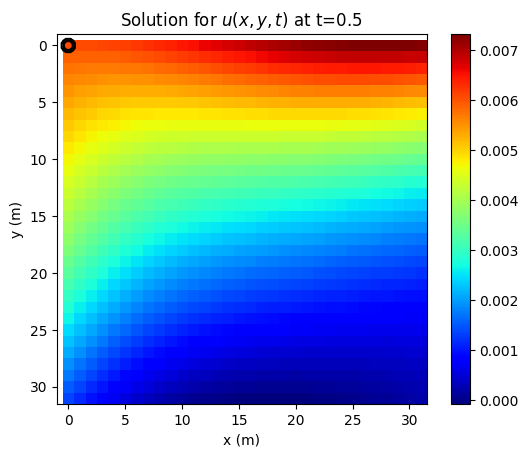

In [62]:
u = model.forward(x.view(-1, 1), y.view(-1, 1), t.view(-1, 1))  # Change 21: Updated forward call
u_np = u.detach().numpy()
u_reshaped = u_np[:, 0].reshape(Nx, Ny, Nt)

x = np.linspace(Lx_initial, Lx_final, Nx)
y = np.linspace(Ly_initial, Ly_final, Ny)
X, Y = np.meshgrid(x, y)

# Compute distance from the cylinder center (assuming centered at origin)
dist_from_center = np.sqrt(X**2 + Y**2)
# Mask for cylinder boundary
cylinder_boundary = np.abs(dist_from_center - r) < 0.1  # Adjust threshold as needed for visibility

plt.imshow(u_reshaped[:, :, Nt // 2], cmap='jet')
plt.title("Solution for $u(x,y,t)$ at t=0.5")
plt.colorbar()
plt.contour(X, Y, cylinder_boundary, colors='k')  # Add cylinder boundary
plt.title("Solution for $u(x,y,t)$ at t=0.5")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()



In [63]:
# once you have a complicated solution so the NN is finding it hard to learn functions.
# to enhance the convergance is 
# MLPs can't capture high frequency details. The proposed solution is FFM
# Fourier feature mapping
# PINNs compared to Numerical Solvers is garbage because high frequency data is not captured.
# CFD simulations are usually done in FORTRAN 